In [2]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

#data
import astsadata

In [29]:
df = astsadata.cmort
df.index = pd.date_range(start='2019-01-01', periods=len(df), freq='D')
print(df.head())
print(df.tail())

             value
2019-01-01   97.85
2019-01-02  104.64
2019-01-03   94.36
2019-01-04   98.05
2019-01-05   95.85
            value
2020-05-18  79.03
2020-05-19  76.56
2020-05-20  78.52
2020-05-21  89.43
2020-05-22  85.49


<function matplotlib.pyplot.show(close=None, block=None)>

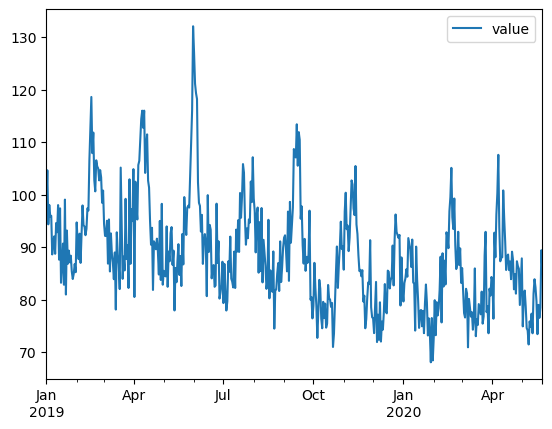

In [4]:
# Plot the data series
df.plot()
plt.show

In [5]:
# Brake into train and test data. Use last 12 values for testing
train = df[:int(len(df)-12)]
test = df[int(len(df))-12:]

print(len(train))
print(len(test))

496
12


In [6]:
# Testing for stationarity. Conduct an Augmented Dickey-Fuller (ADF)
ADF_result = adfuller(train)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -4.655974727891392
p-value: 0.00010172585674190234


The series is stationary since the p-value is below 0.05

<function matplotlib.pyplot.show(close=None, block=None)>

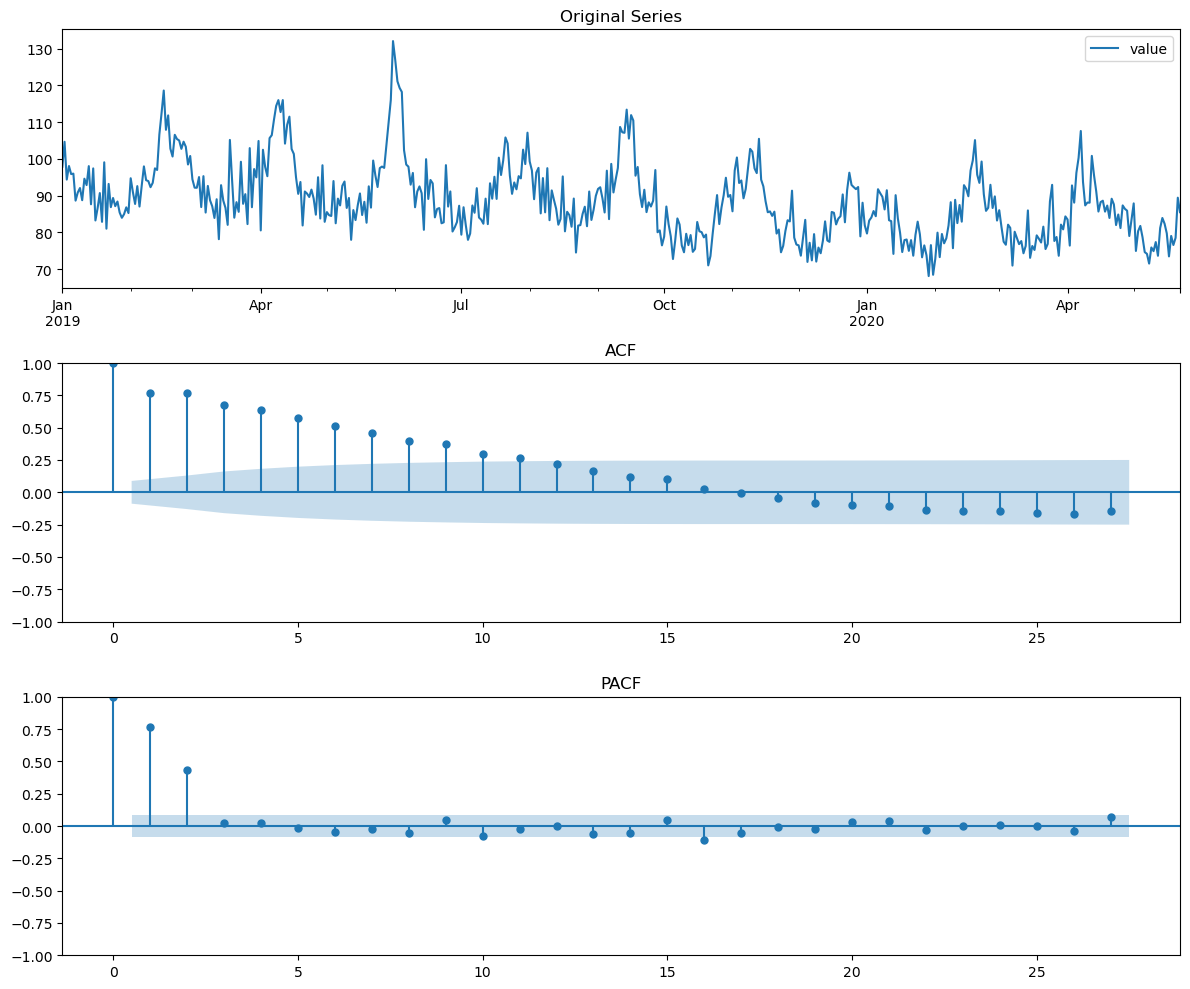

In [7]:
# Plot the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) for the training data.

fig, axes = plt.subplots(nrows=3, figsize=(12, 10))
df.plot(ax=axes[0], title='Original Series')
plot_acf(train, ax=axes[1], title='ACF')
plot_pacf(train, ax=axes[2], title = 'PACF')
plt.tight_layout()
plt.show

Autocorrelation function has 11 legs outside of the confidence level. The ACF is tailing off. We can test MA(11), another option is MA(9).
THe PACF is cutting of after 2 legs.

In [8]:
#demonstration AR(2), MA(11) model
model=SARIMAX(df,order=(2,0,11))
model_fit=model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  508
Model:              SARIMAX(2, 0, 11)   Log Likelihood               -1605.688
Date:                Tue, 15 Oct 2024   AIC                           3239.377
Time:                        18:35:39   BIC                           3298.604
Sample:                    01-01-2019   HQIC                          3262.602
                         - 05-22-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0227      0.022      1.020      0.308      -0.021       0.066
ar.L2          0.9773      0.022     43.915      0.000       0.934       1.021
ma.L1          0.4217      0.117      3.605      0.0

c:\Users\get20\anaconda3\envs\arima\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


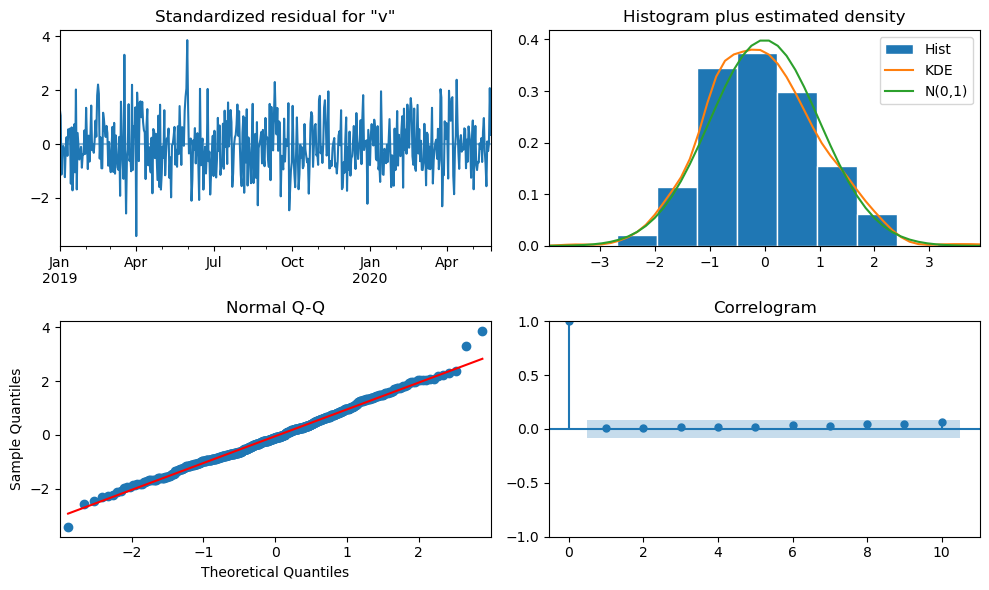

In [9]:
model_fit.plot_diagnostics(figsize=(10, 6))
plt.tight_layout()
plt.show()

In [10]:
#demonstration AR(2), MA(9) model
model2=SARIMAX(df,order=(2,0,9))
model2_fit=model2.fit()
print(model2_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  508
Model:               SARIMAX(2, 0, 9)   Log Likelihood               -1611.443
Date:                Tue, 15 Oct 2024   AIC                           3246.886
Time:                        18:36:08   BIC                           3297.652
Sample:                    01-01-2019   HQIC                          3266.793
                         - 05-22-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0852      0.048      1.765      0.078      -0.009       0.180
ar.L2          0.9137      0.048     18.987      0.000       0.819       1.008
ma.L1          0.3820      0.069      5.504      0.0

c:\Users\get20\anaconda3\envs\arima\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


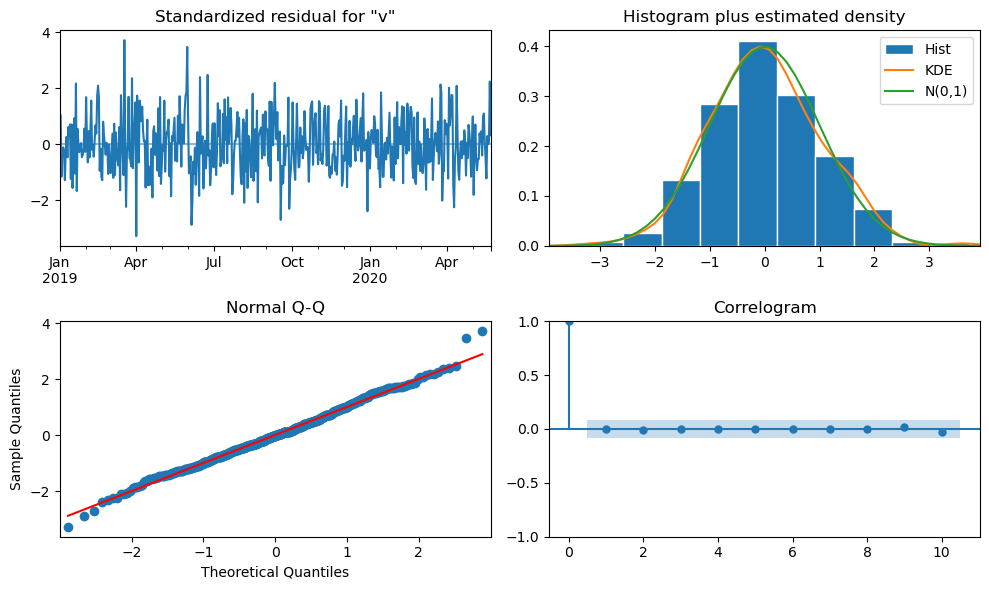

In [11]:
model2_fit.plot_diagnostics(figsize=(10, 6))
plt.tight_layout()
plt.show()

Testing ARIMA(2,0,9) did not improve AIC and reduced significance of parameters MA.L3 and above. The only improvements is KDE distribution. Will use first model. 

Rolling forecast for 1 value

In [12]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, method: str) -> list:

    total_len = train_len + horizon

    if method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.append(last_value)

        return pred_last_value

    elif method == 'ARMA':
        pred_ARMA = []
        low_ci = []
        high_ci = []

        for i in range(train_len, total_len):
            model = SARIMAX(df[:i], order=(2,0,11)) 
            res = model.fit(disp=False)
            predictions = res.get_forecast(1)
            oos_pred = predictions.predicted_mean
            ci = predictions.conf_int()
            pred_ARMA.extend(oos_pred)
            low_ci.extend(ci.iloc[:,0])
            high_ci.extend(ci.iloc[:,1])
        return pred_ARMA, low_ci, high_ci

In [13]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)

pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, 'last')
pred_ARMA, low_ci, high_ci = rolling_forecast(df, TRAIN_LEN, HORIZON, 'ARMA')

pred_df['pred_last_value'] = pred_last_value
pred_df['pred_ARMA'] = pred_ARMA
pred_df['pred_ARMA_low'] = low_ci
pred_df['pred_ARMA_high'] = high_ci

pred_df.head()

c:\Users\get20\anaconda3\envs\arima\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\get20\anaconda3\envs\arima\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\get20\anaconda3\envs\arima\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\get20\anaconda3\envs\arima\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\get20\anaconda3\envs\arima\Lib\site-packages\st

,value,pred_last_value,pred_ARMA,pred_ARMA_low,pred_ARMA_high
2020-05-11,77.36,74.89,75.950773,64.813958,87.087588
2020-05-12,73.63,77.36,77.399562,66.267684,88.531439
2020-05-13,81.17,73.63,78.582041,67.460681,89.703402
2020-05-14,83.91,81.17,78.378738,67.268996,89.488480
2020-05-15,82.36,83.91,83.688903,72.584718,94.793088


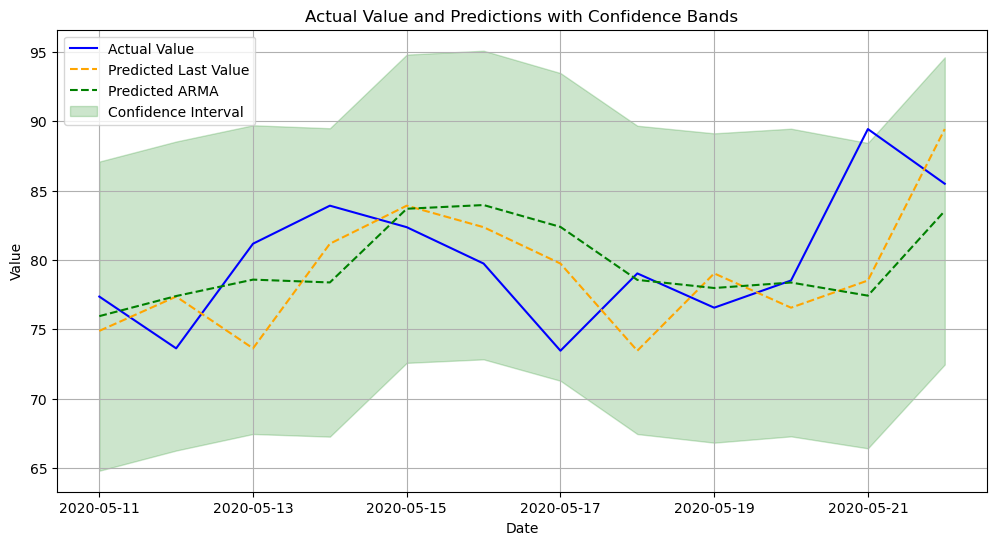

In [14]:
# Create the plot
plt.figure(figsize=(12, 6))

# Plot the actual widget sales
plt.plot(pred_df.index, pred_df['value'], label='Actual Value', color='blue')

# Plot the predicted values (last value method)
plt.plot(pred_df.index, pred_df['pred_last_value'], label='Predicted Last Value', color='orange', linestyle='--')

# Plot the predicted values (moving average method)
plt.plot(pred_df.index, pred_df['pred_ARMA'], label='Predicted ARMA', color='green', linestyle='--')

# Add confidence intervals as shaded areas
plt.fill_between(pred_df.index, pred_df['pred_ARMA_low'], pred_df['pred_ARMA_high'], color='green', alpha=0.2, label='Confidence Interval')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Value and Predictions with Confidence Bands')
plt.legend()
plt.grid(True)
plt.show()

Looking at the Predicted and Actual lines we can see a shift or lag of predicted data by two days. It suggest experimenting with other ARMA parameters to optimize the model.

Next, we will look on forecasting the next 12 values and comparing with actual data.

In [33]:
# Model
#demonstration AR(2), MA(11) model
model=SARIMAX(train,order=(2,0,11))
model_fit=model.fit(disp=False)
forecast = model_fit.get_forecast(12)

# Get predicted values data
forecasted_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Display the predicted values along with confidence intervals
forecast_df = pd.DataFrame({
    'Forecasted': forecasted_values,
    'Lower CI': confidence_intervals.iloc[:, 0],
    'Upper CI': confidence_intervals.iloc[:, 1]
})

# Get actual test last value
test_last = test['value'].tail(1).iloc[0]


c:\Users\get20\anaconda3\envs\arima\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [34]:
print(f'Actual 12th value: {test_last}')
print(f'Forecasted 12th values: \n{forecast_df}')


Actual 12th value: 85.49
Forecasted 12th values: 
            Forecasted   Lower CI    Upper CI
2020-05-11   75.950773  64.813958   87.087588
2020-05-12   76.778975  64.609815   88.948134
2020-05-13   79.396539  65.545435   93.247642
2020-05-14   78.858627  64.155586   93.561667
2020-05-15   80.710297  65.046336   96.374258
2020-05-16   81.323646  64.899136   97.748155
2020-05-17   82.458100  65.536368   99.379832
2020-05-18   82.628150  65.325091   99.931209
2020-05-19   83.142261  65.705295  100.579227
2020-05-20   82.753671  65.076571  100.430771
2020-05-21   83.295209  65.605135  100.985283
2020-05-22   82.762567  65.043768  100.481365


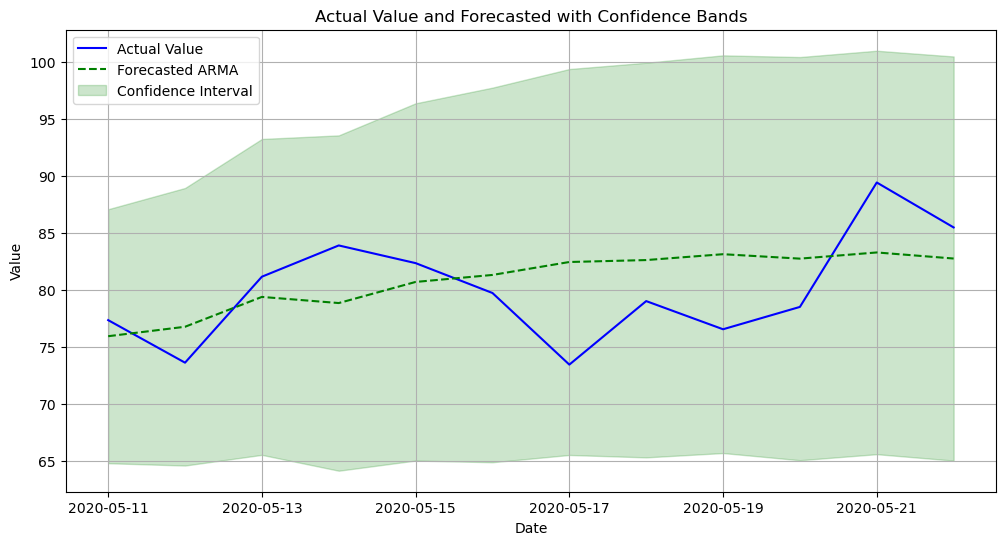

In [35]:
# Create the plot
plt.figure(figsize=(12, 6))

# Plot the actual widget sales
plt.plot(forecast_df.index, test['value'], label='Actual Value', color='blue')

# Plot the predicted values (moving average method)
plt.plot(forecast_df.index, forecast_df['Forecasted'], label='Forecasted ARMA', color='green', linestyle='--')

# Add confidence intervals as shaded areas
plt.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], color='green', alpha=0.2, label='Confidence Interval')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Value and Forecasted with Confidence Bands')
plt.legend()
plt.grid(True)
plt.show()

#### We can see that forecasted values represent very smooth curve compared to actual data.

#### Comparing errors for rolling and forecasted methods

In [38]:
from statsmodels.tools.eval_measures import mse
mse_rolling = mse(pred_df['value'], pred_df['pred_ARMA'])
mse_forecast = mse(test['value'], forecast_df['Forecasted'])

print(mse_rolling, mse_forecast)

25.226932091017304 20.502510502209013


### Summary

Looking at ARMA(2,0,11) model we can note that rolling and forecasting methods produced very different results. Rolling method looked more useful from the plot, but showed larger error when compared with forecasting. Forecasting 12 values ahead looked like smoothed moving average, but showed as superior method with good results.

The downside of the model is it produced large confidence interval. Testing ARIMA(2,0,9) did not produce better model based on AIC and p-values. 

The other models to test would be individual AR(2) and MA(11). The improvement in confidence interval would be desirable.